In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
# from tqdm import tqdm_notebook,trange
import numba
from numba import jit
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.decomposition import PCA
import math
from matplotlib.patches import Ellipse
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
import seaborn as sns
import matplotlib
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler

In [2]:
store_path_base = r"/raid6/roozbeh/trip_similarity/"
data_path_base = r"../data/"
morning_df_parquet_name = r"koln_morning_dataframe.parquet"

In [3]:
if not os.path.isfile(os.path.join(data_path_base, morning_df_parquet_name)):
    store = pd.HDFStore(os.path.join(store_path_base,"kolntr.h5"))
    df = store['kolndf']
    store.close()
    halfday = df[df.time < 13 * 3600]
    morningdf = halfday.groupby('trip_id').apply(lambda tripdf : tripdf if (len(tripdf) >= 50) and (tripdf.time.min() > 6 * 3600 - 30) and (tripdf.time.max() < 10 * 3600 + 30) else None)
    morningdf_no_nan = morningdf[~morningdf.isna().any(axis=1)]
    print(morningdf.trip_id.value_counts(dropna=False))
    print(morningdf_no_nan.trip_id.value_counts(dropna=False))
    print("len(morningdf): {}, len(morningdf_no_nan): {}",len(morningdf),len(morningdf_no_nan))
    morningdf_no_nan.to_parquet('koln_morning_dataframe.parquet')
else:
    print("Morningdf parquet file found. Proceeding.")

Morningdf parquet file found. Proceeding.


In [ ]:
morningdf_no_nan = pd.read_parquet(os.path.join(data_path_base, morning_df_parquet_name))

In [ ]:
morningdf_no_nan

In [ ]:
xmax = morningdf_no_nan.x.max()
xmin = morningdf_no_nan.x.min()
ymax = morningdf_no_nan.y.max()
ymin = morningdf_no_nan.y.min()
tmax = morningdf_no_nan.time.max()
tmin = morningdf_no_nan.time.min()

In [ ]:
def min_max_scaler(series,min_,max_):
    return (series - min_)/(max_ - min_)

In [ ]:
morningdf_no_nan.x = min_max_scaler(morningdf_no_nan.x, xmin, xmax)
morningdf_no_nan.y = min_max_scaler(morningdf_no_nan.y, ymin, ymax)

In [ ]:
# morningdf_no_nan.sort_values(['trip_id','time'])

In [ ]:
def get_trips_50_points(tripdf):
    if len(tripdf) < 50:
        return
    
    tripdf = tripdf.sort_values(by='time').reset_index(drop=True)
    first_48_last = [tripdf.iloc[[0]], tripdf[1:-1].sample(n=48).sort_values(by='time'), tripdf.iloc[[-1]]]
    tripdf = pd.concat(first_48_last,axis=0).reset_index(drop=True)
    return tripdf.drop('trip_id',axis=1)
    

In [ ]:
tempdf = morningdf_no_nan.groupby('trip_id').apply(get_trips_50_points)


In [ ]:
tempdf

In [ ]:
tempdf = tempdf.reset_index(level=1)

In [ ]:
tempdf.rename({'level_1' : 'point_index'},inplace=True,axis=1)

In [ ]:
tempdf

In [ ]:
# tempdf['tupled'] = tempdf.apply(lambda x: (x.time,x.x,x.y,x.spd),axis=1)

In [ ]:
times_matrix = tempdf.pivot_table(index='trip_id',values='time',columns='point_index',aggfunc=lambda x: x)
x_matrix = tempdf.pivot_table(index='trip_id',values='x',columns='point_index',aggfunc=lambda x: x)
y_matrix = tempdf.pivot_table(index='trip_id',values='y',columns='point_index',aggfunc=lambda x: x)
spd_matrix = tempdf.pivot_table(index='trip_id',values='spd',columns='point_index',aggfunc=lambda x: x)

In [ ]:
times_matrix.columns =[str(i) for i in range(50)]
x_matrix.columns = [str(i) for i in range(50)]
y_matrix.columns = [str(i) for i in range(50)]
spd_matrix.columns = [str(i) for i in range(50)]

In [ ]:
times_matrix.to_parquet(os.path.join(data_path_base, 'morning_times_matrix.parquet'))
x_matrix.to_parquet(os.path.join(data_path_base, 'morning_x_matrix.parquet'))
y_matrix.to_parquet(os.path.join(data_path_base, 'morning_y_matrix.parquet'))
spd_matrix.to_parquet(os.path.join(data_path_base, 'morning_spd_matrix.parquet'))

In [ ]:
tempdf.to_parquet(os.path.join(data_path_base, 'morning_trips_df_with_50points.parquet'))

In [4]:
tempdf = pd.read_parquet(os.path.join(data_path_base, 'morning_trips_df_with_50points.parquet'))

## CHECKPOINT
The matrices created represent time, x, y, and speed at corresponding point (column) of the trip (row)

## PLOTTING CONFIG

In [5]:
mpl.rc('text', usetex=True)
# matplotlib.use('Agg')

In [14]:
mpl.rcParams['font.monospace'] = ['Computer Modern Typewriter','DejaVu Sans Mono','Bitstream Vera Sans Mono','Courier']

In [231]:
sns.set(style = 'darkgrid', context = 'paper', font_scale=3)
sns.set_palette("bright")
mpl.rcParams['font.family'] = ['monospace']

In [ ]:
# cyc_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# matplotlib.rcParams.update({'font.size': 20,'xtick.labelsize':30,'ytick.labelsize':30})

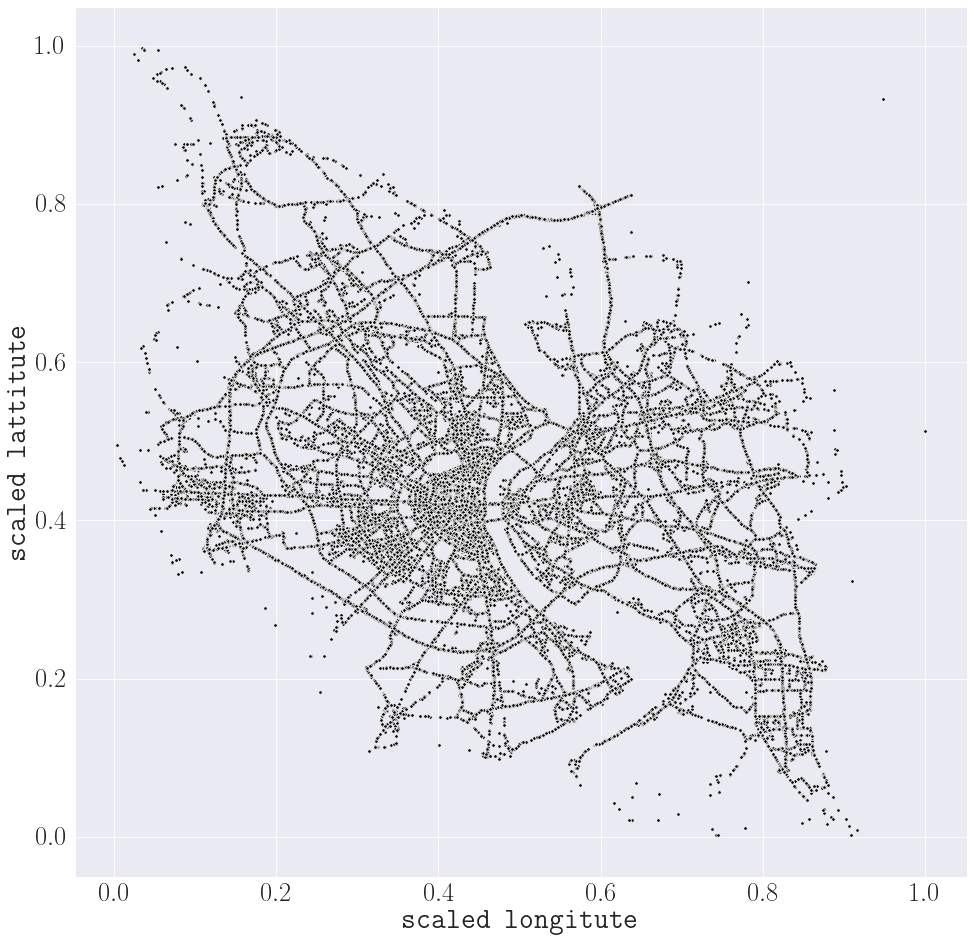

In [173]:
sampledf = tempdf.sample(100000)
plt.figure(figsize=(16,16))
sns.scatterplot(x = sampledf.x,y=sampledf.y, color='black', alpha=1, s=49, marker='.')
plt.ylabel('scaled lattitute')
plt.xlabel('scaled longitute')
del sampledf

------

#### Defining distance/similarity

In [32]:
w_x = 0.5
w_t = 1-w_x
#weighted geometric mean between time and space. arithmetic mean between origin and dest (/2).
@numba.jit(nopython=True)
def get_trip_similarity_wgm(t1,t2):
    odist = np.sqrt( (t1[1] - t2[1]) ** 2 + (t1[2] - t2[2])**2 )
    ddist = np.sqrt( (t1[5] - t2[5]) ** 2 + (t1[6] - t2[6])**2 )
    ot = np.absolute(t1[0]-t2[0])
    dt = np.absolute(t1[4]-t2[4])
    sim = np.exp(w_x * np.log(1./(1+odist)) + w_t * np.log(1./(1+ot)) )
    sim += np.exp(w_x * np.log(1./(1+ddist)) + w_t * np.log(1./(1+dt)) )
    return(sim/2)

##### Let's try getting an affinity matrix

In [33]:
def get_OD_from_50(tripdf):
    return pd.DataFrame([[tripdf.iloc[0,1], tripdf.iloc[0,2], tripdf.iloc[0,3], tripdf.iloc[0,4],
     tripdf.iloc[1,1], tripdf.iloc[1,2], tripdf.iloc[1,3], tripdf.iloc[1,4]]])
    
    

In [34]:
if not os.path.isfile(os.path.join(data_path_base,'morning_ODdf.parquet')):
    ODdf = tempdf.groupby('trip_id').apply(get_OD_from_50)
    ODdf.columns=['orig_time','orig_x','orig_y','orig_spd','dest_time','dest_x','dest_y','dest_spd']
    ODdf.reset_index(level=1,drop=True,inplace=True)
    ODdf.orig_time = min_max_scaler(ODdf.orig_time, tmin, tmax)
    ODdf.dest_time = min_max_scaler(ODdf.dest_time, tmin, tmax)
    ODdf.to_parquet(os.path.join(data_path_base, 'morning_ODdf.parquet'))
else:
    print("ODdf File found. Proceeding.")

ODdf File found. Proceeding.


In [35]:
ODdf = pd.read_parquet(os.path.join(data_path_base,'morning_ODdf.parquet'))

In [36]:
ODdf

,orig_time,orig_x,orig_y,orig_spd,dest_time,dest_x,dest_y,dest_spd
trip_id,,,,,,,,
1000007,26798.0,0.684278,0.570806,0.0,26804.0,0.685274,0.571578,9.74
1000011,23414.0,0.505815,0.250499,0.0,23417.0,0.505366,0.250347,6.08
1000015,23689.0,0.554151,0.161940,0.0,23734.0,0.554292,0.161518,10.15
1000020,26928.0,0.389398,0.389645,0.0,26935.0,0.390773,0.390996,13.07
1000024,25380.0,0.420249,0.567624,0.0,25396.0,0.421578,0.562920,8.20
...,...,...,...,...,...,...,...,...
73013,29902.0,0.804917,0.152156,0.0,29903.0,0.804919,0.152085,2.20
732987,35788.0,0.368885,0.342547,0.0,35792.0,0.369623,0.342151,8.16
734746,27918.0,0.353437,0.634457,0.0,27926.0,0.355882,0.634051,12.66


In [37]:
# sampleODdf = ODdf.sample(frac=0.02) #oops forgot random state!
# sampleODdf.to_parquet(os.path.join(data_path_base, 'morning_sampleODdf.parquet'))
sampleODdf = pd.read_parquet(os.path.join(data_path_base, 'morning_sampleODdf.parquet'))

In [38]:
sampleODdf

,orig_time,orig_x,orig_y,orig_spd,dest_time,dest_x,dest_y,dest_spd
trip_id,,,,,,,,
101976,0.916033,0.248212,0.522616,0.0,0.917139,0.252364,0.519405,7.77
1249482,0.494467,0.678979,0.180198,0.0,0.494743,0.679671,0.179861,7.52
1064676,0.248651,0.376208,0.414576,0.0,0.249620,0.379531,0.413418,7.08
1393720,0.305436,0.400191,0.500733,0.0,0.306474,0.392289,0.500255,13.36
1263272,0.404620,0.345205,0.357355,0.0,0.404897,0.344637,0.357794,8.12
...,...,...,...,...,...,...,...,...
1067705,0.651542,0.402945,0.404750,0.0,0.651681,0.403204,0.404770,3.93
258989,0.373911,0.702427,0.388029,0.0,0.374187,0.701619,0.388220,8.32
1485451,0.632937,0.365770,0.470154,0.0,0.633006,0.365818,0.470127,1.47


In [40]:
sim_matrix = pairwise_distances(sampleODdf,metric=get_trip_similarity_wgm,n_jobs=1)
# sim_matrix = pd.read_parquet(os.path.join(data_path_base, 'sim_matrix_scaled_frac0.02.parquet'))

In [42]:
sim_matrix.shape

(3492, 3492)

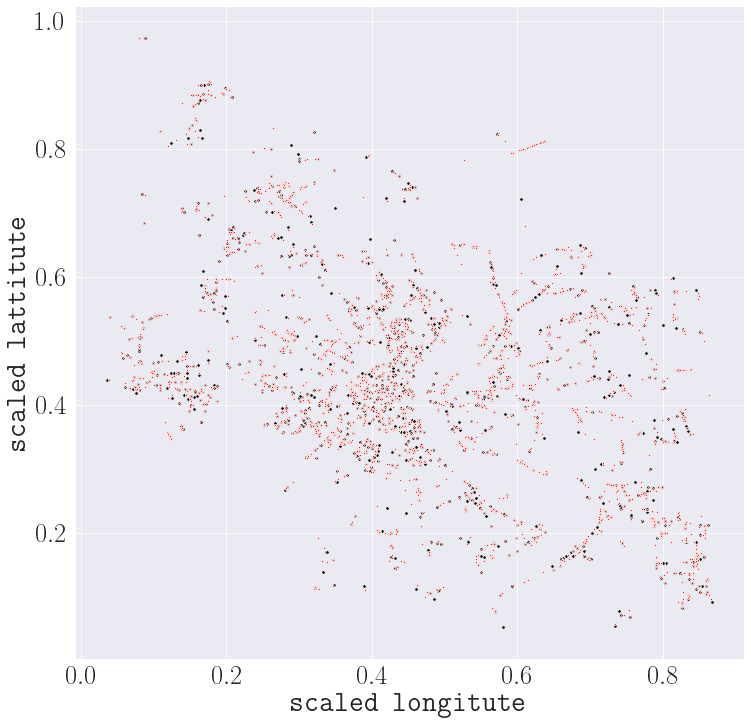

In [174]:
plt.figure(figsize=(12,12))
sns.scatterplot(x = sampleODdf.orig_x,y=sampleODdf.orig_y, color='black', s=12)
sns.scatterplot(x = sampleODdf.dest_x,y=sampleODdf.dest_y, color='red', marker='.', alpha=0.9, s=16)
plt.ylabel('scaled lattitute')
plt.xlabel('scaled longitute');

-----

-------

### Attempting clustering

In [146]:
sim_matrix_lkern = np.exp(-1 * sim_matrix  )

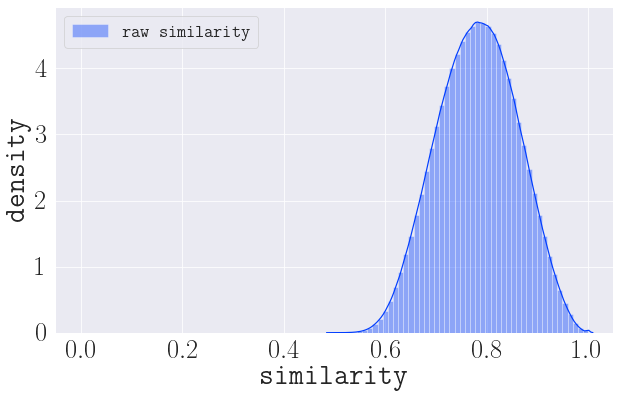

In [148]:
plt.figure(figsize=(10,6))
ax =  sns.distplot(np.reshape(sim_matrix,-1),norm_hist=False,label="raw similarity")
# ax =  sns.distplot(np.reshape(sim_matrix_lkern,-1),norm_hist=True,ax=ax,label="laplacian kernel")
ax.set_xlabel("similarity")
ax.set_xlim((-0.05,1.05))
ax.set_ylabel("density")
plt.legend(prop= {"size" : 18})
plt.show()

In [63]:
xyt_columns = ['orig_time','orig_x','orig_y','dest_time','dest_x','dest_y']

In [64]:
pca_obj = PCA(n_components=3)

In [65]:
pca_obj.fit(sampleODdf[xyt_columns])

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [66]:
pca_obj.explained_variance_ratio_

array([0.50141665, 0.35251165, 0.1459557 ])

In [67]:
spc_obj = SpectralClustering(n_clusters = 4, affinity='precomputed',n_jobs=-1,assign_labels="discretize",random_state=54321)

In [68]:
spc_obj.fit(sim_matrix)

SpectralClustering(affinity='precomputed', assign_labels='discretize', coef0=1,
                   degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=4, n_components=None,
                   n_init=10, n_jobs=-1, n_neighbors=10, random_state=54321)

In [69]:
Counter(spc_obj.labels_)

Counter({1: 815, 3: 797, 0: 934, 2: 946})

In [72]:
pca_projection = pca_obj.transform(sampleODdf[xyt_columns])

In [ ]:
# cmap = plt.cm.get_cmap('jet', 24)

In [ ]:
# mpl.colors.to_hex(cmap(5))

In [ ]:
# mpl.rcParams['font.family'] = 'sans-serif'

Per below cell, first component is more focused on longitute while the second component is a combination of latitute and time (for both origin and destination points).

In [70]:
pca_obj.components_

array([[ 0.70598704, -0.04055922,  0.01410157,  0.70562792, -0.04047173,
         0.0137723 ],
       [-0.04182329, -0.61474127,  0.34689272, -0.04246323, -0.61526079,
         0.34591973],
       [ 0.00751077,  0.34751905,  0.6181706 ,  0.00794205,  0.34568158,
         0.61439432]])

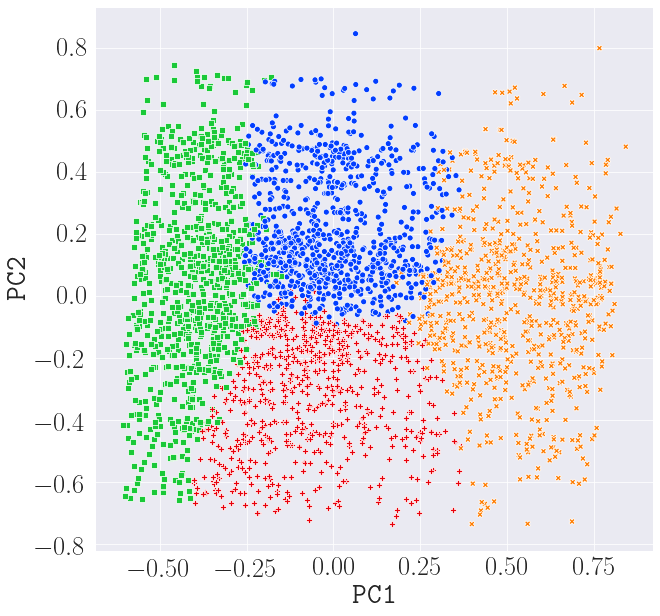

In [177]:
plt.figure(figsize=(10,10))
sns.scatterplot(pca_projection[:,0],
                pca_projection[:,1],
                s=36,
                alpha=1,
                hue_order=[0,1,2,3],
                hue=spc_obj.labels_,
                style=spc_obj.labels_,
                style_order = [0,1,2,3],
                legend=False,
                palette=sns.color_palette('bright')[:4])
ax = plt.gca()
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.show()

In [98]:
from sklearn.manifold import spectral_embedding

In [99]:
spc_embedding = spectral_embedding(sim_matrix,n_components=2)

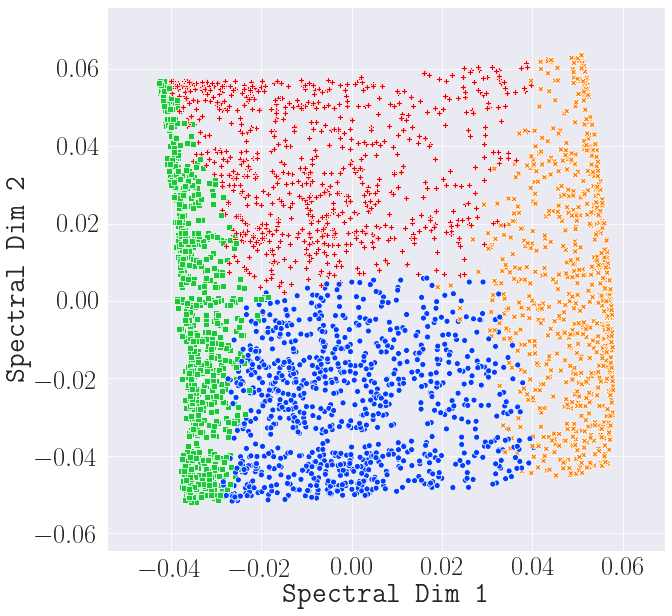

In [178]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(spc_embedding[:,0]*100,spc_embedding[:,1]*100,
                     s=36,
                     alpha=1,
                     hue=spc_obj.labels_,
                     hue_order=[0,1,2,3],
                     style=spc_obj.labels_,
                     style_order = [0,1,2,3],
                     legend=False,
                     palette=sns.color_palette('bright')[:4]
                    )
ax.set_xlabel("Spectral Dim 1")
ax.set_ylabel("Spectral Dim 2")#,fontsize=24)
# ax.legend(loc='upper right', bbox_to_anchor=(1.01, 1.01), ncol=1,borderpad=0.2)
plt.show()

In [186]:
#For adjusting aesthetics of legend:
# borderpad          the fractional whitespace inside the legend border
# labelspacing       the vertical space between the legend entries
# handlelength       the length of the legend handles
# handletextpad      the pad between the legend handle and text
# borderaxespad      the pad between the axes and legend border
# columnspacing      the spacing between columns

In [156]:
from scipy.sparse import csgraph
from numpy import linalg as LA
L = csgraph.laplacian(sim_matrix, normed=True)
eigenvalues, eigenvectors = LA.eig(L)

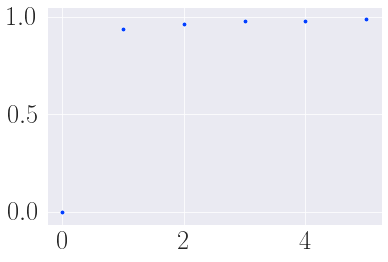

In [158]:
sns.scatterplot(y=eigenvalues[:6],x=range(6))

In [179]:
eigenvalues

array([-5.84951831e-17,  9.39017168e-01,  9.60534754e-01, ...,
        1.00035409e+00,  1.00035410e+00,  1.00035410e+00])

In [180]:
index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:5]

In [181]:
index_largest_gap + 1

array([1, 2, 3, 5, 6], dtype=int64)

<IPython.core.display.Javascript object>


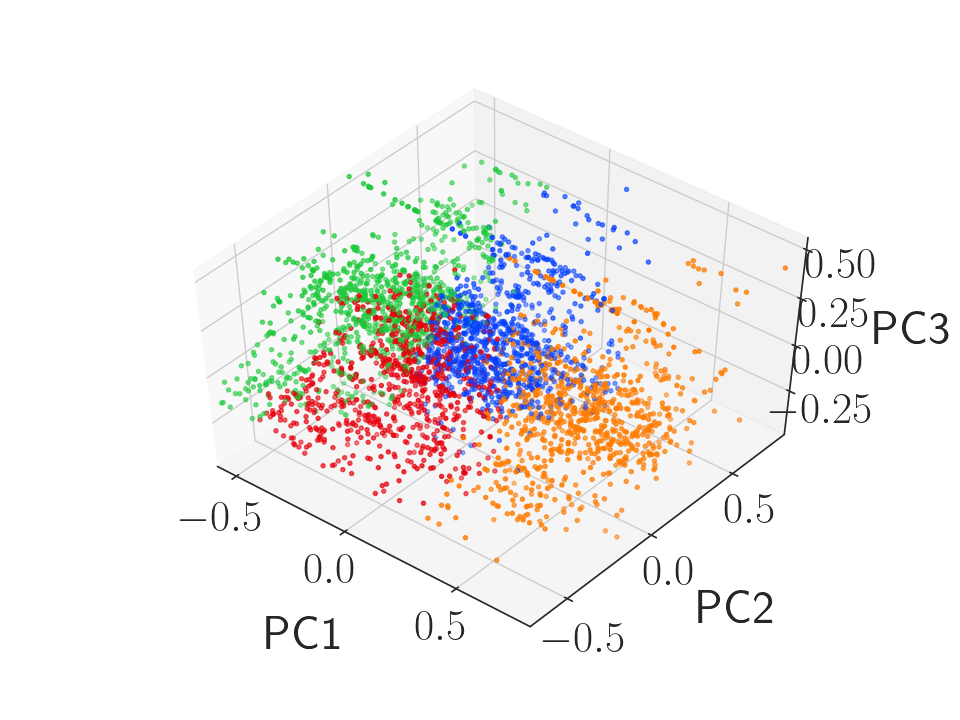

In [210]:
%matplotlib notebook
sns.set_style('white')
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_projection[:,0],pca_projection[:,1],pca_projection[:,2],
           s=6,
           c=[sns.color_palette('bright')[i] for i in spc_obj.labels_],)
ax.set_xlabel('PC1')
ax.xaxis.labelpad = 30
ax.set_ylabel('PC2')
ax.yaxis.labelpad = 30
ax.set_zlabel('PC3')
ax.zaxis.labelpad = 20
plt.show()

In [216]:
%matplotlib inline

In [ ]:
mds_obj = MDS(n_jobs=-1,dissimilarity='precomputed')

-----

----

Plot every point?

In [ ]:
pca_projection_all = pca_obj.transform(OD)

In [ ]:
plt.figure(figsize=(28,18))
plt.scatter(pca_projection_all[:,0],pca_projection_all[:,1],s=0.1)
plt.show()

------

Let's try a simple euclidean distance in R^6

In [211]:
eucl_dist = pairwise_distances(sampleODdf[xyt_columns],metric='euclidean')

In [212]:
euc_sim = 1/(1+eucl_dist)

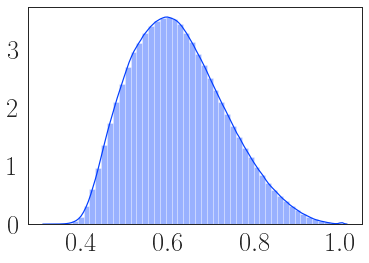

In [217]:
ax =  sns.distplot(np.reshape(euc_sim,-1),norm_hist=False,label="raw similarity")

In [218]:
spc_obj_eucl = SpectralClustering(n_clusters=4,affinity='rbf')

In [219]:
spc_obj_eucl.fit(sampleODdf[xyt_columns])

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=4, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=10, random_state=None)

In [220]:
Counter(spc_obj_eucl.labels_)

Counter({1: 804, 0: 728, 3: 1088, 2: 872})

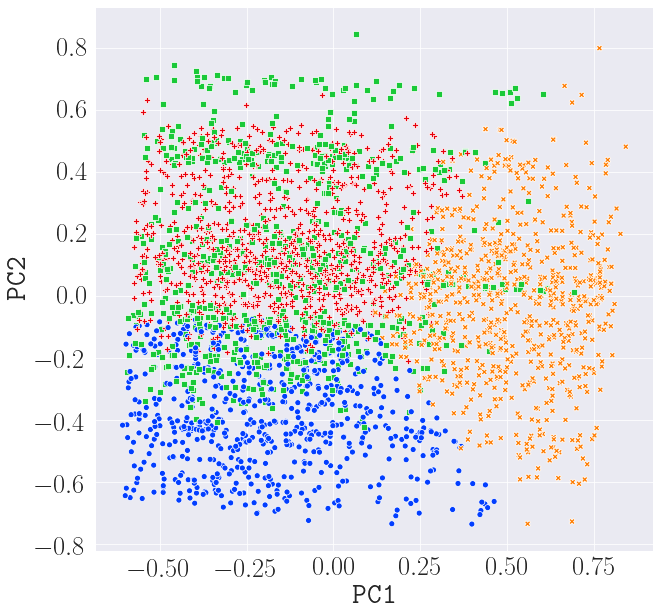

In [224]:
plt.figure(figsize=(10,10))
sns.scatterplot(pca_projection[:,0],
                pca_projection[:,1],
                s=36,
                alpha=1,
                hue_order=[0,1,2,3],
                hue=spc_obj_eucl.labels_,
                style=spc_obj_eucl.labels_,
                style_order = [0,1,2,3],
                legend=False,
                palette=sns.color_palette('bright')[:4])
ax = plt.gca()
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.show()

In [228]:
def get_ellipse(cluster,clr):
    data_x = cluster.orig_x.append(cluster.dest_x)
    data_y = cluster.orig_y.append(cluster.dest_y)

    avg_x = np.mean(data_x)
    avg_y = np.mean(data_y)
    x_diff = data_x - avg_x
    y_diff = data_y - avg_y
    x_diff_sq = [i**2 for i in x_diff]
    slope = sum(x*y for x,y in zip(x_diff,y_diff)) / sum(x_diff_sq)
    return(Ellipse((avg_x,avg_y),2*data_x.std(),2*data_y.std(),math.degrees(math.atan(slope)),facecolor='none',lw=1,edgecolor=clr))

In [238]:
def get_ellipses_figure(ODdf, cluster_labels):
    n_cluster = len(set(cluster_labels))
#     colors = [mpl.colors.to_hex(cmap(i/n_cluster)) for i in range(n_cluster)]
    colors = sns.color_palette("bright", n_cluster)
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111,aspect='equal')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    for i in range(n_cluster):
        cluster = ODdf[cluster_labels == i]
        ax.scatter(np.mean(cluster.orig_x),np.mean(cluster.orig_y),c=[colors[i]])
        ax.scatter(np.mean(cluster.dest_x),np.mean(cluster.dest_y),c=[colors[i]],marker='s')
        ax.add_artist(get_ellipse(cluster,colors[i]))
    ax.set_xlabel("Scaled longitute",fontsize=22)
    ax.set_ylabel("Scaled latitude",fontsize=22)
    return ax

In [239]:
sns.set(style = 'darkgrid', context = 'paper', font_scale=3)
sns.set_palette("bright")
mpl.rcParams['font.family'] = ['monospace']

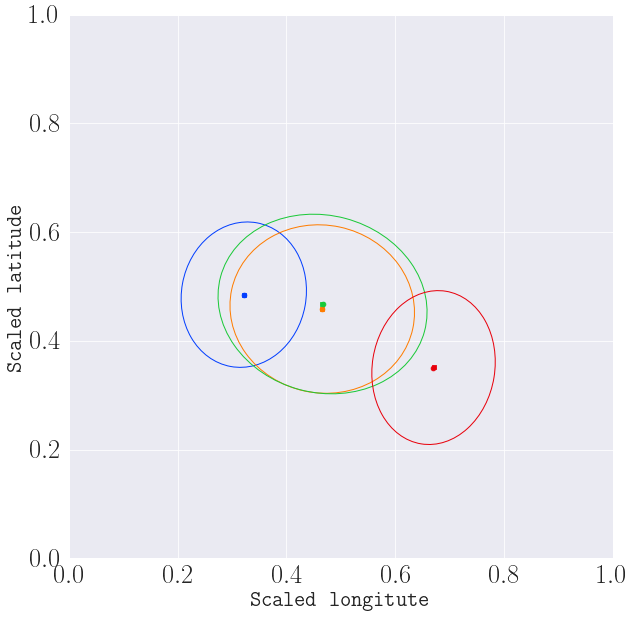

In [240]:
get_ellipses_figure(sampleODdf, spc_obj.labels_)

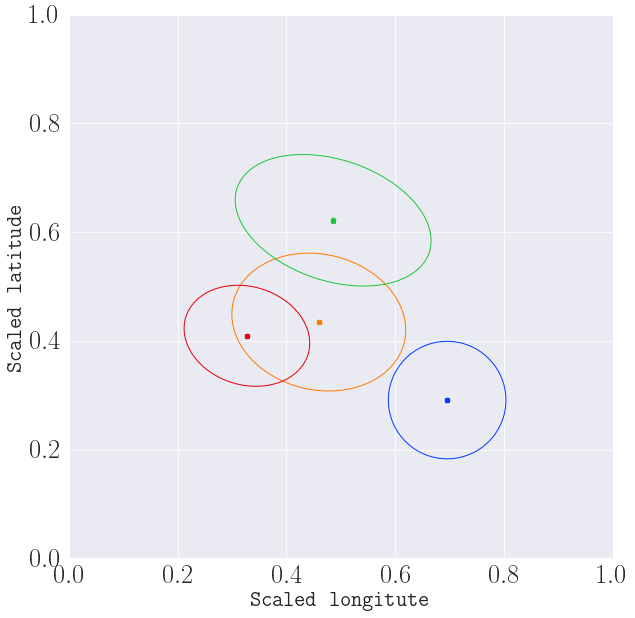

In [241]:
get_ellipses_figure(sampleODdf, spc_obj_eucl.labels_)

In [267]:
ODdf.columns = ['orig time','orig x','orig y','orig spd','dest time','dest x','dest y','dest spd']
sampleODdf.columns = ['orig time','orig x','orig y','orig spd','dest time','dest x','dest y','dest spd']

In [274]:
def get_kdes_for_times(ODdf, cluster_labels):
    n_cluster = len(set(cluster_labels))
    fig = plt.figure(figsize=(14,10))

    g = sns.JointGrid(x=ODdf['orig time'],y=ODdf['dest time'], height =10)
    
    colors = sns.color_palette("bright", n_cluster)
#     colors = ['blue','red','purple','green']
#     colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c']
    for i in range(n_cluster):
        cluster = ODdf[cluster_labels == i]
        sns.kdeplot(cluster['orig time'],cluster['dest time'],
                          shade=True,
                          shade_lowest=False,
                          legend=True,
                          color=colors[i],
                          ax=g.ax_joint)        
#         print(len(g.ax_joint.collections))
        sns.distplot(cluster['orig time'], kde=False, color=colors[i], ax=g.ax_marg_x, label='orig time')
        sns.distplot(cluster['dest time'], kde=False, color=colors[i], ax=g.ax_marg_y, vertical=True, label='dest time')
    for coll in g.ax_joint.collections:
        if coll.get_alpha() is None:
            coll.set_alpha(0.4)
#     g.ax_joint.collections[0].set_alpha(0)
#     g.ax_joint.collections[10].set_alpha(0)
#     g.ax_joint.collections[19].set_alpha(0)
#     g.ax_joint.collections[29].set_alpha(0)
    g.ax_marg_x.set_xlabel('')
    g.ax_marg_y.set_ylabel('')
    return g


<Figure size 1008x720 with 0 Axes>

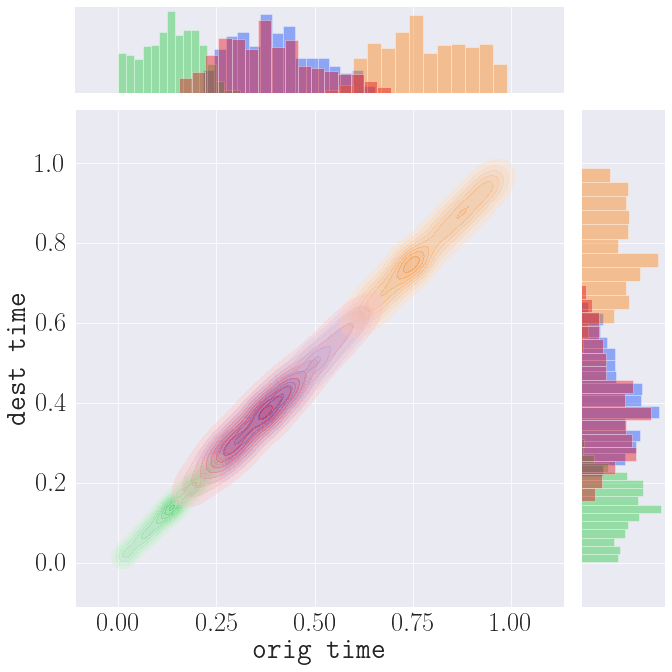

In [275]:
# sns.set_context('paper',font_scale=3)
get_kdes_for_times(sampleODdf, spc_obj.labels_)
plt.show()

<Figure size 1008x720 with 0 Axes>

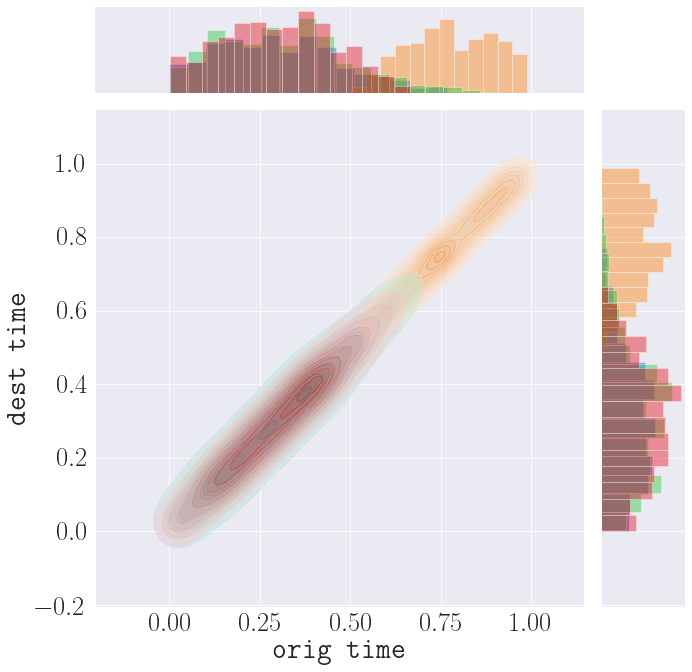

In [276]:
get_kdes_for_times(sampleODdf, spc_obj_eucl.labels_)
plt.show()